 # K-nearest-neighbours (KNN)
## Etapes:
#### 1. Chargement des  données
- Charger les images et les étiquettes (malade ou non) à partir des dossiers de données.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

from src.preprocessing import load_images_from_folder
import os

base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/raw_test"))

train_path = os.path.join(base_path, "train")

X, y = load_images_from_folder(train_path, image_size=(64, 64))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)


#### 2.Normalisation et prétraitement
- Ajuster les valeurs des pixels pour qu'elles soient dans une plage spécifique (souvent 0 à 1)
- Transformer chaque image 2D (64x64 pixels) en un vecteur 1D (4096 éléments.

In [6]:
from src.augment import augment_images_to_balance

X_train_augmented, y_train_augmented = augment_images_to_balance(
    X_train, y_train
)
import numpy as np
from src.preprocessing import normalize_images

normalized_images = normalize_images(X_train_augmented)
flattened_images = np.array([x.flatten() for x in normalized_images])

test_normalized_images = normalize_images(X_test)
test_flattened_images = np.array([x.flatten() for x in test_normalized_images])

#### 3. Définition des hyperparamètres et validation croisée : 
- On définit une  grille d'hyperparamètres pour tester différents nombres de voisins (k).
- Utiliser GridSearchCV pour trouver le meilleur hyperparamètre n_neighbors avec validation croisée.


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

param_grid = {'n_neighbors': np.arange(1, 31)}

knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

#### 4.Récupération du Meilleur Nombre de Voisins
- Entraîner le modèle KNN avec les données d'entraînement après les avoir aplaties.
- Identifier le meilleur nombre de voisins (k) trouvé par GridSearchCV.

In [8]:
knn_gscv.fit(flattened_images, y_train_augmented)

# Récupération du meilleur nombre de voisins et du meilleur score
best_k = knn_gscv.best_params_['n_neighbors']
best_score = knn_gscv.best_score_
print(f'Best number of neighbors: {best_k}')
print(f'Best cross-validated score: {best_score:.4f}')  

Best number of neighbors: 6
Best cross-validated score: 0.9290


#### 5.Entraînement du modèle avec le meilleur k sur les données augmentées
- Créer un nouveau modèle KNN avec le meilleur n_neighbors trouvé et l'entraîner sur les données d'entraînement augmentéés.

In [9]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(flattened_images, y_train_augmented)

KNeighborsClassifier(n_neighbors=6)

#### 6.Évaluation sur l'ensemble de test
- Évaluer les performances du modèle KNN optimal sur un ensemble de test indépendant.

In [10]:
from sklearn.model_selection import cross_val_score

best_clf = knn_gscv.best_estimator_
scores = cross_val_score(best_clf, flattened_images, y_train_augmented, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {scores}")
print(f"Score moyen de validation croisée : {np.mean(scores)}")

y_pred = best_clf.predict(test_flattened_images)

from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy sur les données de test : {accuracy_score(y_test, y_pred)}")
print(f"Rapport de classification :\n {classification_report(y_test, y_pred)}")

Scores de validation croisée : [0.84470435 0.85445094 0.98439532 0.97789337 0.98374512]
Score moyen de validation croisée : 0.9290378211579133
Accuracy sur les données de test : 0.9266211604095563
Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       159
           1       0.92      0.98      0.95       427

    accuracy                           0.93       586
   macro avg       0.93      0.88      0.90       586
weighted avg       0.93      0.93      0.92       586



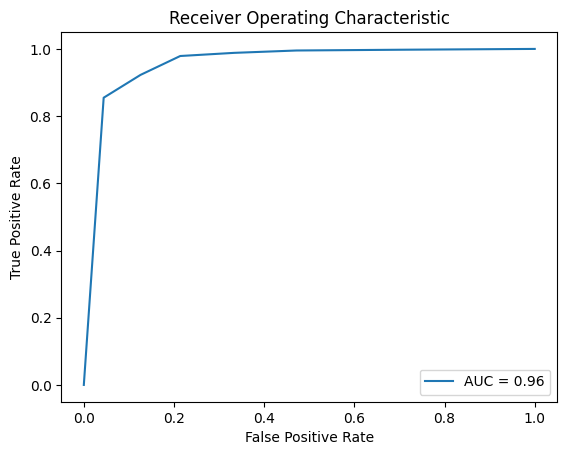

In [11]:
y_test_pred_proba = knn_best.predict_proba(test_flattened_images)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()